In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import sklearn.model_selection
import sklearn.preprocessing

%matplotlib inline

### Load Data

In [2]:
df = pd.read_pickle('data/processed.pkl')
df = df.set_index('DATE')  # Index for timeseries is datetime

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 592 entries, 1963-01-01 to 2012-04-01
Data columns (total 20 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   MSACSR                                                                     592 non-null    float64
 1   MSPUS                                                                      592 non-null    float64
 2   S&P Comp.                                                                  592 non-null    float64
 3   Dividend                                                                   592 non-null    float64
 4   Earnings                                                                   592 non-null    float64
 5   Consumer Price Index CPI                                                   592 non-null    float64
 6   Long Interest Rate GS10                

### Data Interpolation

In [3]:
# Todo: Data interpolation if necessary

### Data Preprocessing

In [4]:
# Split into input and target variables

X = df.drop('MSPUS', axis='columns')
y = df['MSPUS'].values
y = y.reshape(-1, 1)  # Put target variable into column vector shape

print(X.shape)
print(y.shape)

(592, 19)
(592, 1)


In [5]:
# Scale data

standard_scaler = sklearn.preprocessing.StandardScaler()  # Scales to mean of 0 and var of 1
minmax_scaler = sklearn.preprocessing.MinMaxScaler()  # Scale to between 0 and 1

X_scaled = standard_scaler.fit_transform(X)  
y_scaled = minmax_scaler.fit_transform(y)    

print("X mean:", X_scaled.mean())
print("X var:", X_scaled.var())
print("y min:", y_scaled.min())
print("y max:", y_scaled.max())

X mean: -3.916576246188319e-16
X var: 1.0
y min: 0.0
y max: 1.0000000000000002


In [6]:
# NOTE: These values are for monthly data
#       Change these if interpolating!
IN_SEQ_LENGTH = 10
OUT_SEQ_LENGTH = 5

def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(len(input_sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        if out_end_ix > len(input_sequences):
            break
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
        
    return np.array(X), np.array(y)

X_seq, y_seq = split_sequences(X_scaled, y_scaled, IN_SEQ_LENGTH, OUT_SEQ_LENGTH)

# Make 
print(X_seq.shape, y_seq.shape)

assert y_seq[0].all() == y_scaled[IN_SEQ_LENGTH-1:IN_SEQ_LENGTH-1+OUT_SEQ_LENGTH].squeeze(1).all()

(579, 10, 19) (579, 5)


In [30]:
TEST_SIZE = 0.05

# Split data into train and test sets
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_seq, y_seq, test_size=TEST_SIZE)

# Convert datasets to nodes in computational graph
X_train_tensors = torch.Tensor(X_train)
y_train_tensors = torch.Tensor(y_train)
X_val_tensors = torch.Tensor(X_val)
y_val_tensors = torch.Tensor(y_val)

# Convert to sequential data for pytorch
X_train_tensors = torch.reshape(X_train_tensors, 
                                (X_train_tensors.shape[0], IN_SEQ_LENGTH, X_train_tensors.shape[2])
                               )
X_val_tensors = torch.reshape(X_val_tensors, (X_val_tensors.shape[0], IN_SEQ_LENGTH, X_val_tensors.shape[2]))


print(X_train_tensors.shape)
print(X_val_tensors.shape)

torch.Size([550, 10, 19])
torch.Size([29, 10, 19])


In [8]:
# Sanity Check data
X_check, y_check = split_sequences(X, y.reshape(-1, 1), IN_SEQ_LENGTH, OUT_SEQ_LENGTH)
print(X_check[-1][0:4])

start_ix = IN_SEQ_LENGTH + OUT_SEQ_LENGTH

#print(X.iloc[-start_ix + 1: -start_ix + 5])

[[7.2000000e+00 1.3044900e+03 2.3430000e+01 8.1310000e+01 2.2347000e+02
  3.4100000e+00 1.6948900e+03 3.0440000e+01 8.8240620e+05 1.0564000e+02
  5.5001150e+04 2.2900000e+01 2.5270000e+01 3.3600000e+00 1.0000000e+00
  4.3690000e+01 1.1900000e+01 1.9500000e+00 9.9500000e+00]
 [6.7000000e+00 1.3315100e+03 2.3730000e+01 8.2160000e+01 2.2491000e+02
  3.4600000e+00 1.7189300e+03 3.0640000e+01 8.9625005e+05 1.0607000e+02
  5.5304800e+04 2.3140000e+01 2.5530000e+01 3.2900000e+00 1.0300000e+00
  4.3350000e+01 1.2290000e+01 1.9400000e+00 1.0360000e+01]
 [6.6000000e+00 1.3383100e+03 2.4040000e+01 8.3020000e+01 2.2596000e+02
  3.1700000e+00 1.7196200e+03 3.0890000e+01 8.9795133e+05 1.0667000e+02
  5.5700790e+04 2.3060000e+01 2.5420000e+01 3.6000000e+00 1.0200000e+00
  4.4330000e+01 1.2270000e+01 1.6600000e+00 1.0610000e+01]
 [6.6000000e+00 1.2872900e+03 2.4340000e+01 8.3870000e+01 2.2572000e+02
  3.0000000e+00 1.6558300e+03 3.1310000e+01 8.6600739e+05 1.0788000e+02
  5.6422440e+04 2.2100000e+01 2

### Model

In [9]:
# Define model

class LSTM(torch.nn.Module):
    def __init__(self, n_classes, n_inputs, n_hidden, n_layers):
        super().__init__()
        self.n_classes = n_classes  # Output size
        self.n_inputs = n_inputs  # Input size
        self.n_hidden = n_hidden
        self.n_layers = n_layers  # Number of reccurrent layers
        
        self.lstm = torch.nn.LSTM(input_size=n_inputs, 
                                  hidden_size=n_hidden,
                                  num_layers=n_layers,
                                  batch_first=True,  # Input/Output layers are of the form (batch, seq, feature)
                                  dropout=0.2  # Dropout helps to avoid over-fitting/improves robustness
                                 )
        self.fc1 = torch.nn.Linear(n_hidden, 128)  # Fully connected layer 1
        self.fc2 = torch.nn.Linear(128, n_classes)  # Fully connected layer 2
        self.relu = torch.nn.ReLU()  # Activation layer
        
    def forward(self, X):
        # Initialize hidden state
        h_0 = torch.Tensor(torch.zeros(self.n_layers, X.size(0), self.n_hidden))
        # Initialize cell state
        c_0 = torch.Tensor(torch.zeros(self.n_layers, X.size(0), self.n_hidden))
        
        # Forward propogate inputs
        output, (h_n, c_n) = self.lstm(X, (h_0, c_0))
        h_n = h_n.view(-1, self.n_hidden)
        out = self.relu(h_n)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

In [10]:
# Define training loop

def training_loop(n_epochs, lstm, optimizer, loss_fn, X_train, y_train, X_test, y_test):
    for epoch_i in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train)  # Forward pass
        optimizer.zero_grad()  # Calculate gradient, manually set to 0
        loss = loss_fn(outputs, y_train)
        loss.backward()  # Calculate loss
        optimizer.step()  # Backpropogate loss

        # Test set loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch_i % 100 == 0:
            print("Epoch {}: Train loss: {:.8f} Test loss: {:.15f}".format(epoch_i, 
                                                                          loss.item(),
                                                                          test_loss.item()
                                                                         )
                 )

In [15]:
# Run model


# Define model parameters
N_EPOCHS = 10000
LEARNING_RATE = 0.001

INPUT_SIZE = X.shape[1]  # Number of features
HIDDEN_SIZE = 10  # Number of features in hidden state
N_LAYERS = 1 # Number of stacked lstm layers

N_CLASSES = OUT_SEQ_LENGTH  # Equal to how many timesteps in future we want to predict

lstm1 = LSTM(N_CLASSES,
            INPUT_SIZE,
            HIDDEN_SIZE,
            N_LAYERS
           )

# Define loss function
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm1.parameters(), lr=LEARNING_RATE)

# Run training loop
training_loop(n_epochs=N_EPOCHS,
              lstm=lstm1,
              optimizer=optimizer,
              loss_fn=loss_fn,
              X_train=X_train_tensors,
              y_train=y_train_tensors,
              X_test=X_val_tensors,
              y_test=y_val_tensors
             )

Epoch 0: Train loss: 0.24628602 Test loss: 0.257878571748734
Epoch 100: Train loss: 0.00212084 Test loss: 0.002428826177493
Epoch 200: Train loss: 0.00055869 Test loss: 0.000520960311405
Epoch 300: Train loss: 0.00028580 Test loss: 0.000250963144936
Epoch 400: Train loss: 0.00019334 Test loss: 0.000197241577553
Epoch 500: Train loss: 0.00014663 Test loss: 0.000171701161889
Epoch 600: Train loss: 0.00011695 Test loss: 0.000152202715981
Epoch 700: Train loss: 0.00010127 Test loss: 0.000132934612338
Epoch 800: Train loss: 0.00009008 Test loss: 0.000117096147733
Epoch 900: Train loss: 0.00008199 Test loss: 0.000104910955997
Epoch 1000: Train loss: 0.00007595 Test loss: 0.000093352115073
Epoch 1100: Train loss: 0.00007108 Test loss: 0.000083842271124
Epoch 1200: Train loss: 0.00006694 Test loss: 0.000076691045251
Epoch 1300: Train loss: 0.00006331 Test loss: 0.000070943940955
Epoch 1400: Train loss: 0.00006019 Test loss: 0.000066774577135
Epoch 1500: Train loss: 0.00005742 Test loss: 0.0000

### Plot Results

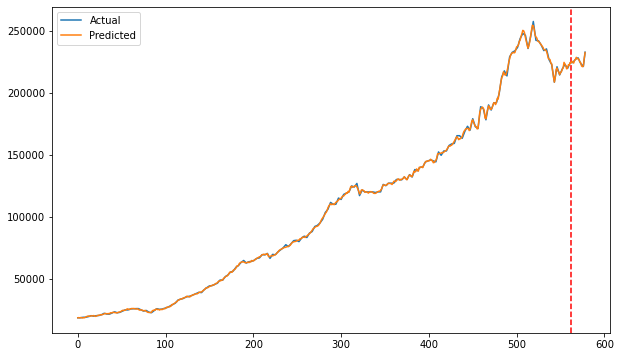

In [37]:
# Plot predictions vs actual

# Get data into the right format
X_tensors = torch.Tensor(X_seq)
y_tensors = torch.Tensor(y_seq)

X_tensors = torch.reshape(X_tensors, (X_tensors.shape[0], IN_SEQ_LENGTH, X_tensors.shape[2]))

# Get predictions and actual
predictions_scaled = lstm1(X_tensors).data.numpy()  # Convert to numpy for plotting
actual_scaled = y_tensors.data.numpy()

# Reverse scaling transformations
predictions_seq = minmax_scaler.inverse_transform(predictions_scaled)  # y values used minmax scaler earlier
actual_seq = minmax_scaler.inverse_transform(actual_scaled)

# Reverse sequence transformations
predictions = [predictions_seq[i][0] for i in range(len(predictions_seq))]
actual = [actual_seq[i][0] for i in range(len(actual_seq))]

# Plot
plt.figure(figsize=(10, 6))

train_test_cutoff = round((1-TEST_SIZE) * X.shape[0])  # Index where test data starts
plt.axvline(x=train_test_cutoff, c='red', linestyle='--')

plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()